# **Import needed libraries**

In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the dataset**

> Read the training dataset into the dataframe

In [2]:
import os
import pandas as pd

def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df
    
def change_label_names(df, column_name):
    index = {'n0': 'mantled_howler', 'n1': 'patas_monkey', 'n2': 'bald_uakari', 'n3': 'japanese_macaque', 
        'n4': 'pygmy_marmoset', 'n5': 'white_headed_capuchin', 'n6': 'silvery_marmoset', 
        'n7': 'common_squirrel_monkey', 'n8': 'black_headed_night_monkey', 'n9': 'nilgiri_langur'}

    df[column_name] = df[column_name].replace(index)

# Define data directory
data_dir = 'archive/training/training'  # Update with your data directory

# Load the data
train_df = loading_the_data(data_dir)

# Change label names
change_label_names(train_df, 'labels')


In [3]:
change_label_names(train_df, 'labels')

In [4]:
train_df

,filepaths,labels
0,archive/training/training\n0\n0018.jpg,mantled_howler
1,archive/training/training\n0\n0019.jpg,mantled_howler
2,archive/training/training\n0\n0020.jpg,mantled_howler
3,archive/training/training\n0\n0021.jpg,mantled_howler
4,archive/training/training\n0\n0022.jpg,mantled_howler
...,...,...
1093,archive/training/training\n9\n9161.jpg,nilgiri_langur
1094,archive/training/training\n9\n9162.jpg,nilgiri_langur
1095,archive/training/training\n9\n9163.jpg,nilgiri_langur
1096,archive/training/training\n9\n917.jpg,nilgiri_langur


> read the testing dataset into the dataframe

In [5]:
# Define data directory for validation data
data_dir_validation = 'archive/validation/validation'  # Update with your validation data directory

# Load the validation data
ts_df = loading_the_data(data_dir_validation)


In [6]:
change_label_names(ts_df, 'labels')

In [7]:
ts_df

,filepaths,labels
0,archive/validation/validation\n0\n000.jpg,mantled_howler
1,archive/validation/validation\n0\n001.jpg,mantled_howler
2,archive/validation/validation\n0\n0010.jpg,mantled_howler
3,archive/validation/validation\n0\n0011.jpg,mantled_howler
4,archive/validation/validation\n0\n0012.jpg,mantled_howler
...,...,...
267,archive/validation/validation\n9\n912.jpg,nilgiri_langur
268,archive/validation/validation\n9\n913.jpg,nilgiri_langur
269,archive/validation/validation\n9\n914.jpg,nilgiri_langur
270,archive/validation/validation\n9\n916.jpg,nilgiri_langur


# **Data preprocessing**
first we will check if the training data is balanced or not

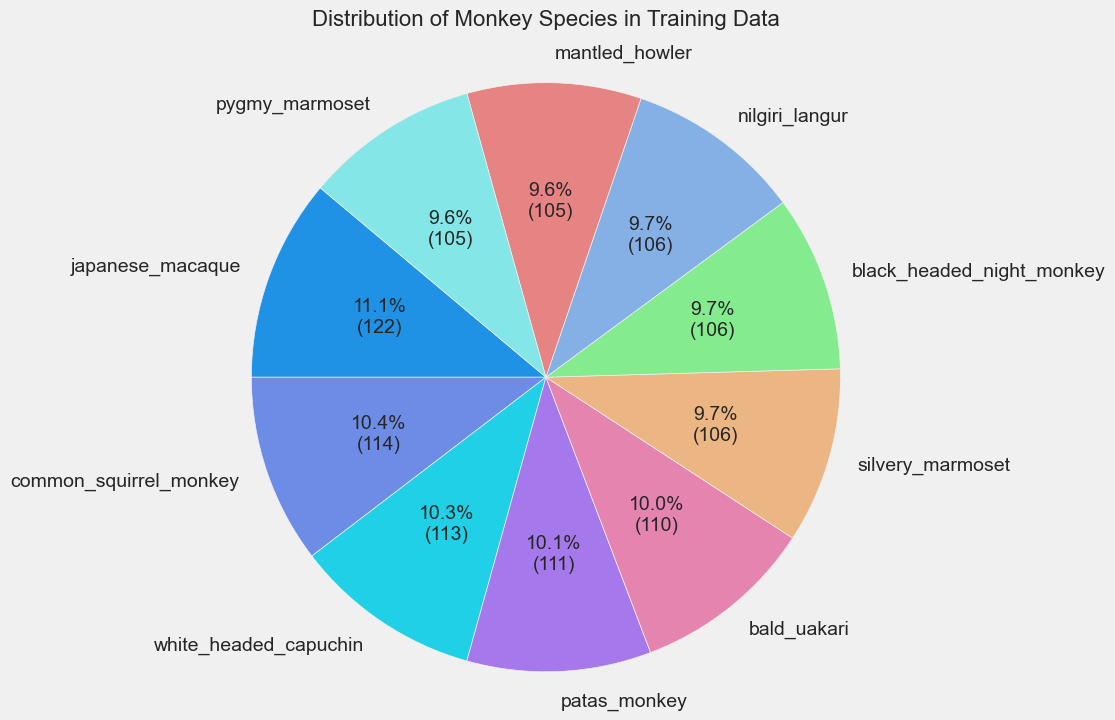

In [23]:
import matplotlib.pyplot as plt

# Calculate data balance
data_balance = train_df.labels.value_counts()

# Define a custom function for autopct
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

# Define colors
colors = ["#2092E6", "#6D8CE6", "#20D0E6", "#A579EB", "#E684B0", "#EBB684", "#84EB8E", "#84B0E6", "#E68484", "#84E6E6"]

# Create a pie chart for data balance
plt.figure(figsize=(8, 8))  # Set the size of the figure
plt.pie(data_balance, labels=data_balance.index, autopct=custom_autopct, colors=colors, startangle=140)  # Adjust start angle for better visualization
plt.title("Distribution of Monkey Species in Training Data", fontsize=16, pad=20)  # Add a title with larger font size and padding
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


It is balanced but very small, so we will augment this training data

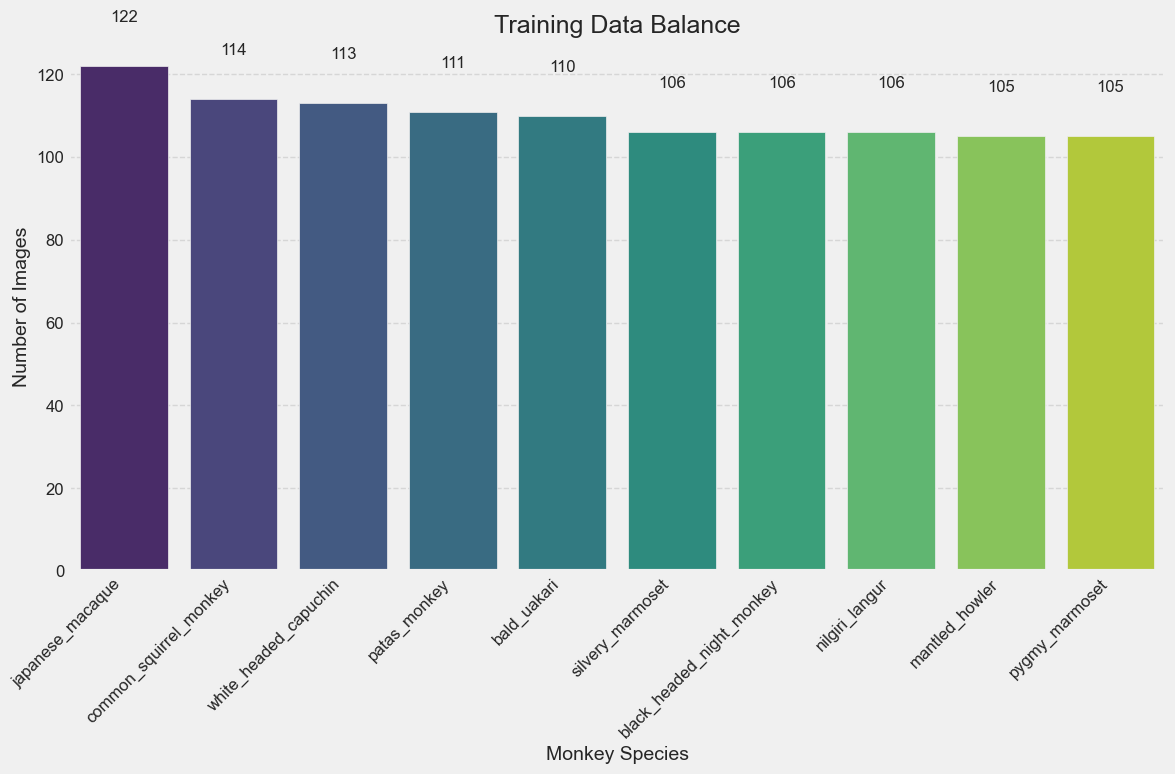

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate data balance
data_balance = train_df.labels.value_counts()

# Create bar plot for data balance
plt.figure(figsize=(12, 8))
sns.barplot(x=data_balance.index, y=data_balance.values, palette="viridis")
plt.title("Training Data Balance", fontsize=18)
plt.xlabel("Monkey Species", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for index, value in enumerate(data_balance.values):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


In [9]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

**Create image data generator**

in this step we will augment training data and converting the whoole data to numpy arrays

In [35]:
# crobed image size
batch_size = 8
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255,
                           rotation_range=20,       # Random rotations from 0 to 20 degrees
                           width_shift_range=0.2,   # Random horizontal shifts
                           height_shift_range=0.2,  # Random vertical shifts
                           zoom_range=0.3,          # Random zoom
                           horizontal_flip=True,    # Random horizontal flips
                           fill_mode='nearest'      # Strategy for filling in newly created pixels
                           )
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1098 validated image filenames belonging to 10 classes.
Found 136 validated image filenames belonging to 10 classes.
Found 136 validated image filenames belonging to 10 classes.


**Display sample from train data**

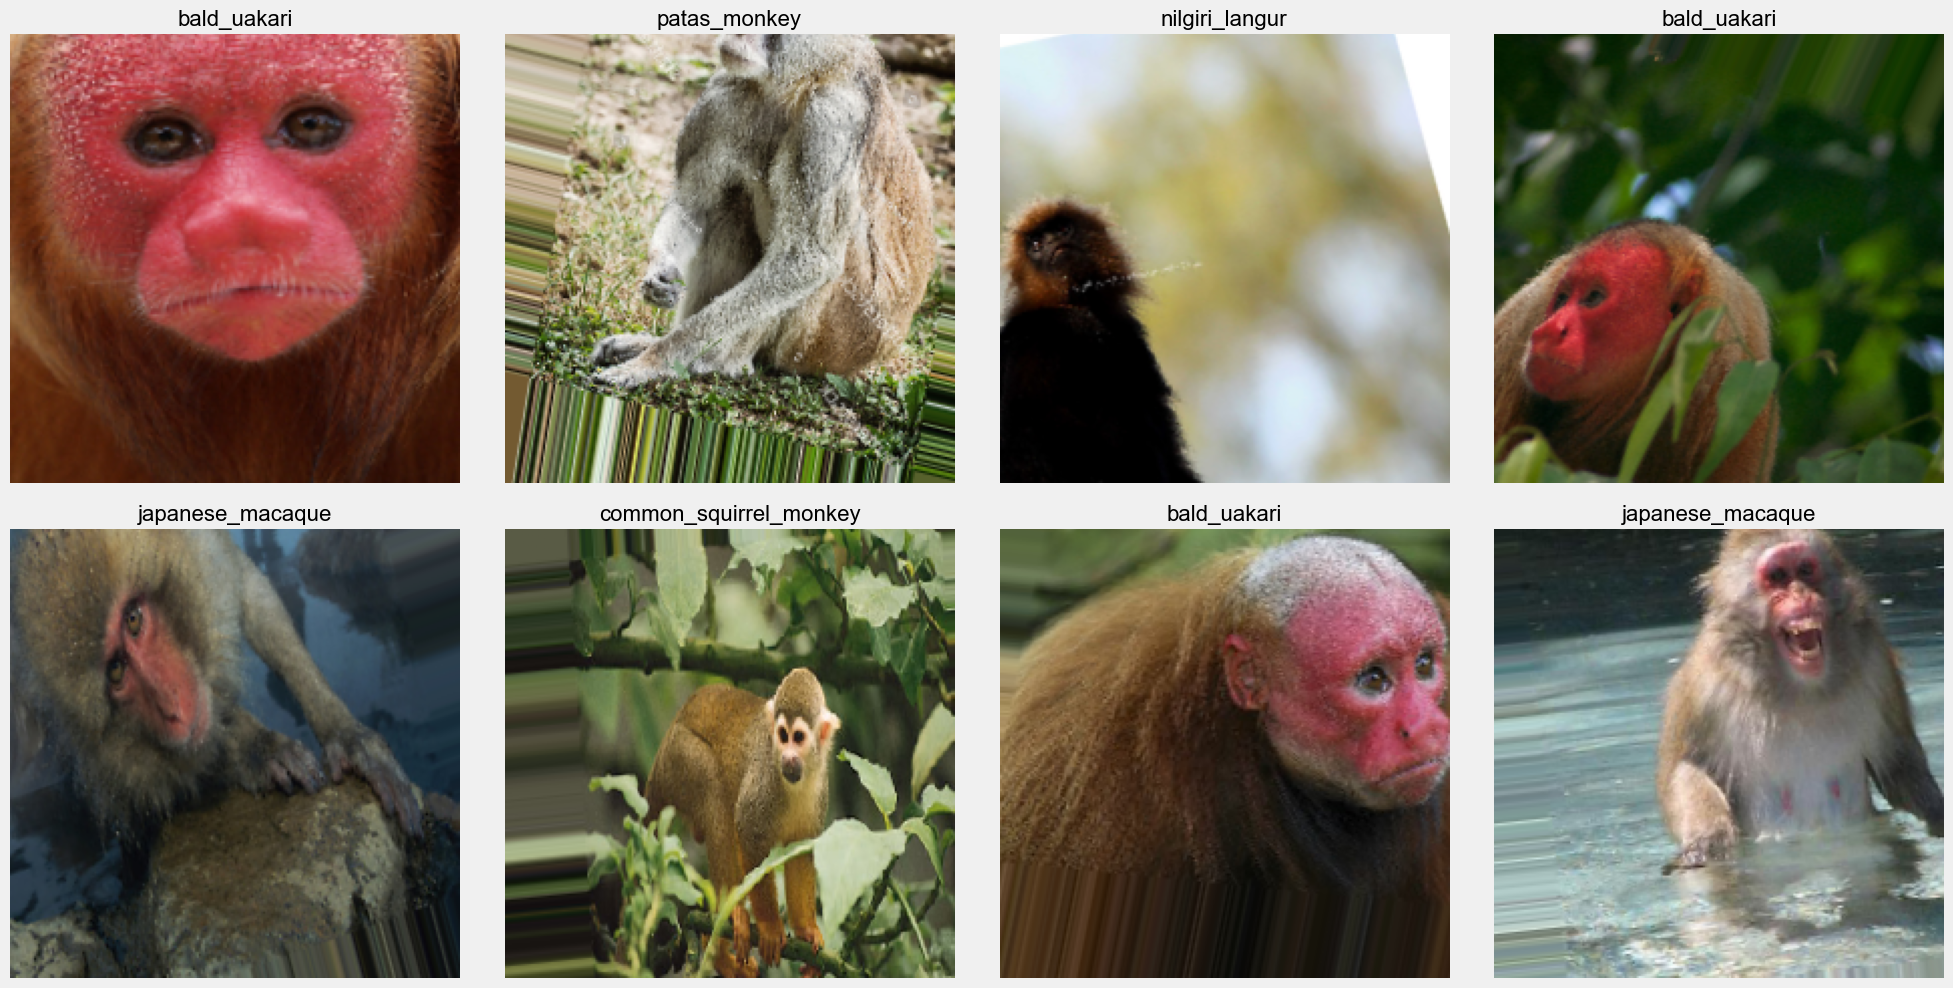

In [36]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Structure**

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers

# Define input shape
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Get the number of classes
class_counts = len(train_gen.class_indices)

# Get the pre-trained model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')

# Freeze convolutional blocks
for layer in base_model.layers[:15]:
    layer.trainable = False

# Fine-tune VGG16 (Adding custom layers on top)
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.5)(x)  # Increased Dropout Rate
x = Dense(256, activation=LeakyReLU(alpha=0.1))(x)  # Different Activation Functions
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dense(64, activation='relu')(x)  # Additional Dense Layer
x = Dense(32, activation='relu')(x)  # Additional Dense Layer
predictions = Dense(class_counts, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [39]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

**Train the model**

In [43]:
epochs = 100  # number of all epochs in training
batch_size = 8   # number of batches

history = model.fit(train_gen, epochs= epochs, verbose= 1,batch_size = batch_size, validation_data= valid_gen, shuffle= False)

Epoch 1/100
138/138 [==============================] - 31s 224ms/step - loss: 7.7343 - accuracy: 0.2905 - val_loss: 8.0593 - val_accuracy: 0.1912
Epoch 2/100
138/138 [==============================] - 31s 227ms/step - loss: 7.2953 - accuracy: 0.3843 - val_loss: 7.6158 - val_accuracy: 0.2647
Epoch 3/100
138/138 [==============================] - 31s 225ms/step - loss: 6.9234 - accuracy: 0.4727 - val_loss: 6.7360 - val_accuracy: 0.4485
Epoch 4/100
138/138 [==============================] - 32s 230ms/step - loss: 6.6454 - accuracy: 0.4863 - val_loss: 6.4212 - val_accuracy: 0.5221
Epoch 5/100
138/138 [==============================] - 33s 236ms/step - loss: 6.3375 - accuracy: 0.5410 - val_loss: 6.0666 - val_accuracy: 0.6103
Epoch 6/100
138/138 [==============================] - 33s 237ms/step - loss: 6.1528 - accuracy: 0.5428 - val_loss: 6.1997 - val_accuracy: 0.4632
Epoch 7/100
138/138 [==============================] - 31s 228ms/step - loss: 5.8362 - accuracy: 0.6047 - val_loss: 5.6368 -

**Display model performance**

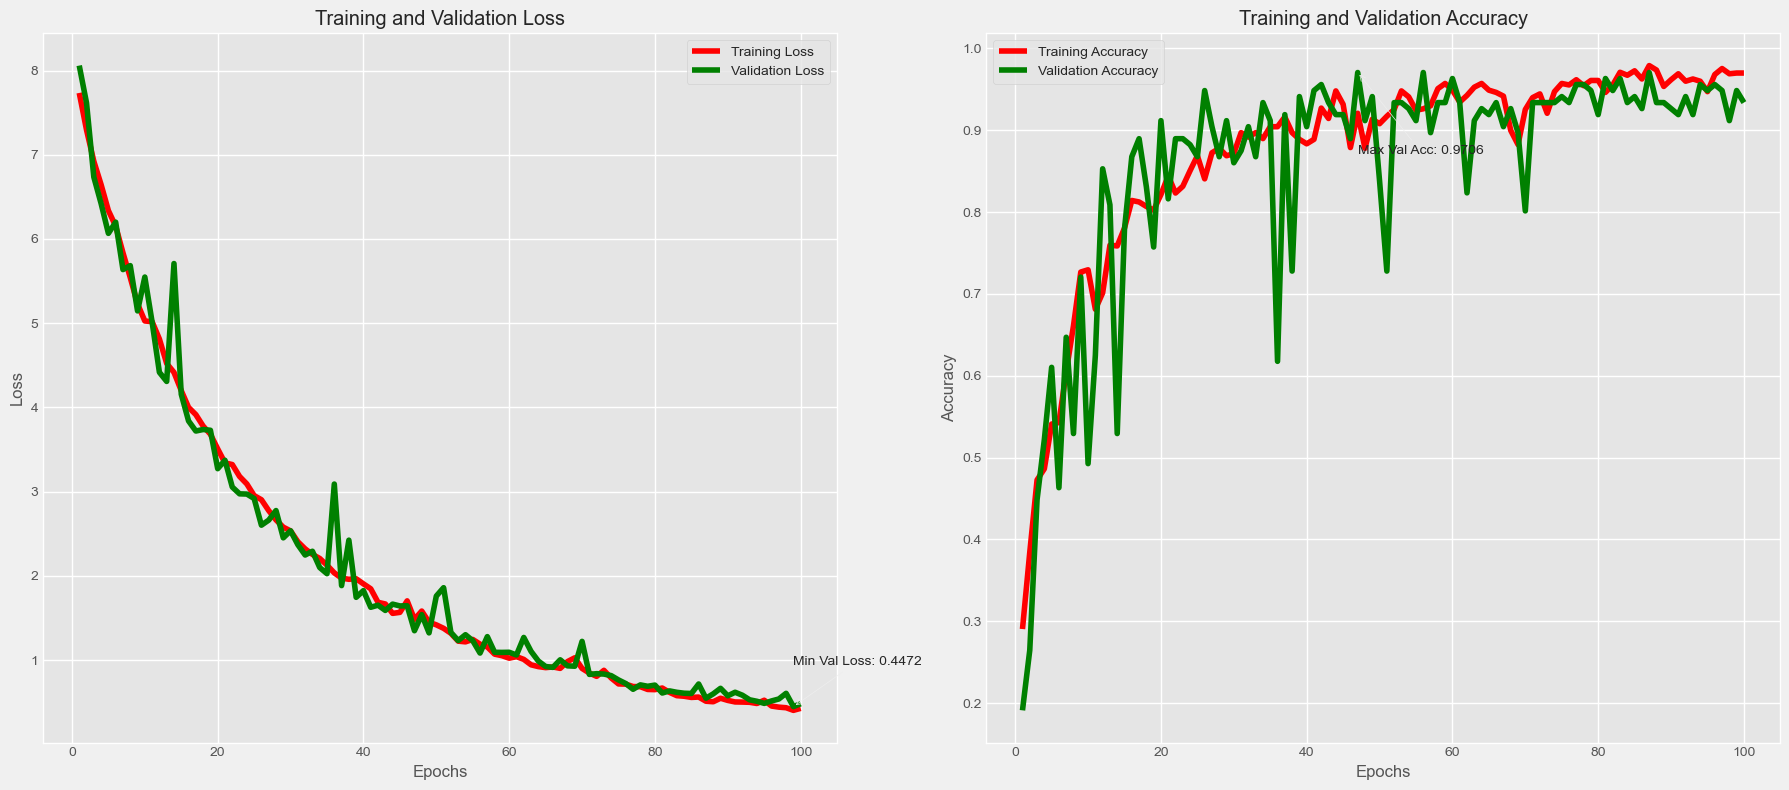

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Epochs = range(1, len(tr_acc) + 1)

# Plot training history
plt.figure(figsize=(18, 8))
plt.style.use('ggplot')

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Annotate the minimum validation loss
min_val_loss = min(val_loss)
min_val_loss_epoch = val_loss.index(min_val_loss) + 1
plt.annotate(f'Min Val Loss: {min_val_loss:.4f}', xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch, min_val_loss + 0.5),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Annotate the maximum validation accuracy
max_val_acc = max(val_acc)
max_val_acc_epoch = val_acc.index(max_val_acc) + 1
plt.annotate(f'Max Val Acc: {max_val_acc:.4f}', xy=(max_val_acc_epoch, max_val_acc),
             xytext=(max_val_acc_epoch, max_val_acc - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.tight_layout()
plt.show()


# **Evaluate the model**

17/17 [==============================] - 2s 118ms/step - loss: 0.6433 - accuracy: 0.8971


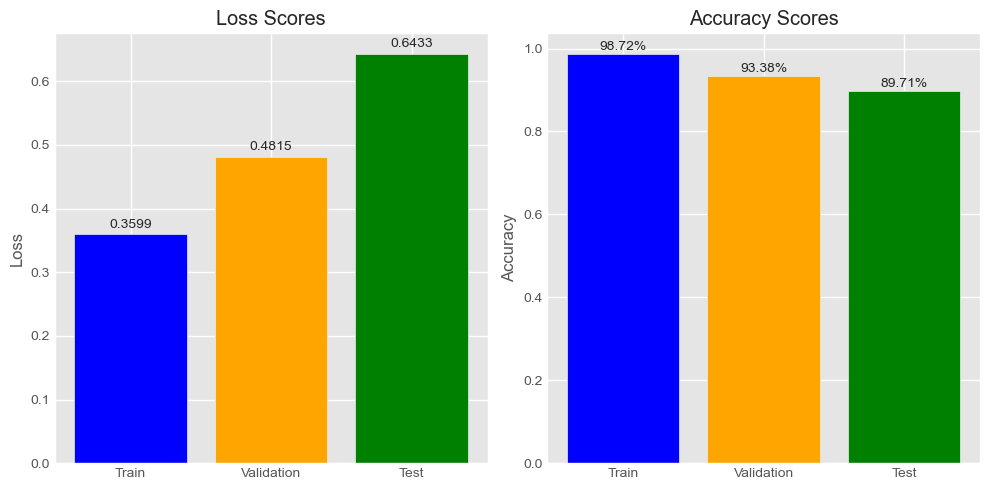

========== Evaluation Results ==========
Train Loss: 0.3599 | Train Accuracy: 98.72%
Validation Loss: 0.4815 | Validation Accuracy: 93.38%
Test Loss: 0.6433 | Test Accuracy: 89.71%


In [52]:
import matplotlib.pyplot as plt

# Get evaluation scores
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

# Define labels and scores
labels = ['Train', 'Validation', 'Test']
loss_scores = [train_score[0], valid_score[0], test_score[0]]
accuracy_scores = [train_score[1], valid_score[1], test_score[1]]

# Plot loss scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, loss_scores, color=['blue', 'orange', 'green'])
plt.title('Loss Scores')
plt.ylabel('Loss')
for i in range(len(labels)):
    plt.text(i, loss_scores[i] + 0.01, f'{loss_scores[i]:.4f}', ha='center')
plt.tight_layout()

# Plot accuracy scores
plt.subplot(1, 2, 2)
plt.bar(labels, accuracy_scores, color=['blue', 'orange', 'green'])
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
for i in range(len(labels)):
    plt.text(i, accuracy_scores[i] + 0.01, f'{accuracy_scores[i]*100:.2f}%', ha='center')
plt.tight_layout()

# Show plots and print scores
plt.show()

print(f"{'='*10} Evaluation Results {'='*10}")
for label, loss, acc in zip(labels, loss_scores, accuracy_scores):
    print(f"{label} Loss: {loss:.4f} | {label} Accuracy: {acc*100:.2f}%")


# **Get Predictions**

In [46]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

17/17 [==============================] - 2s 125ms/step


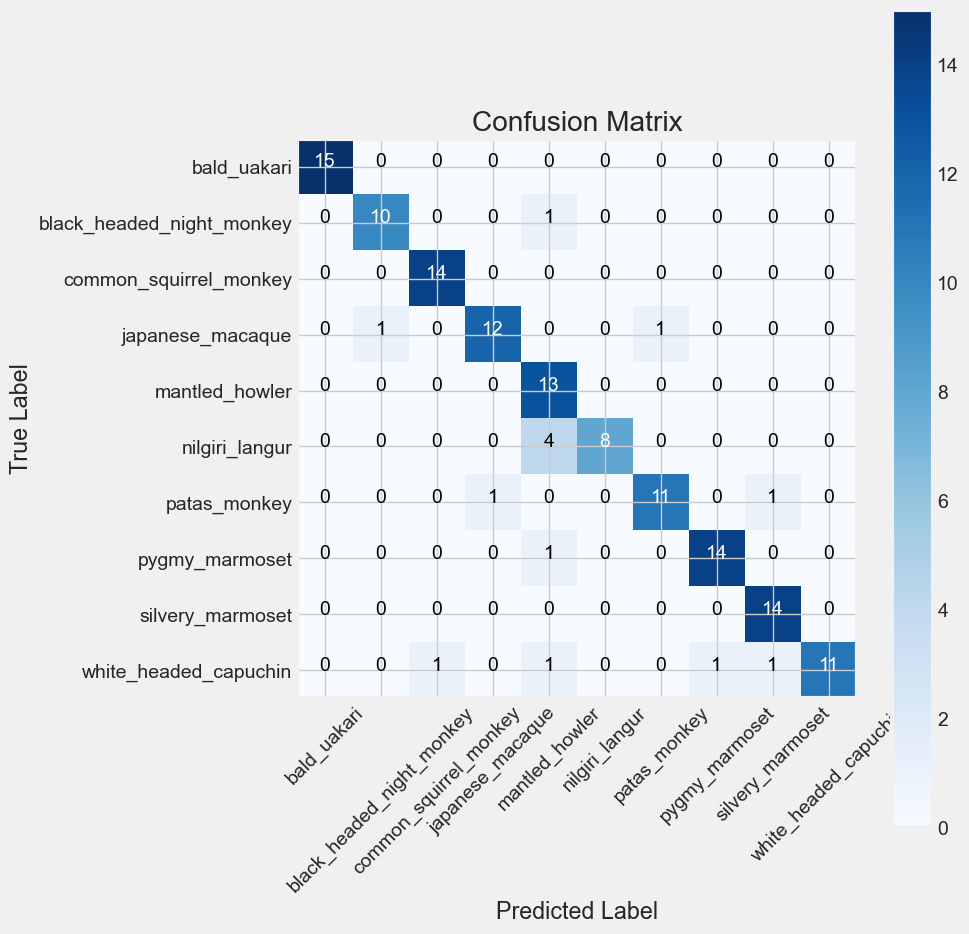

In [48]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()